# Detecting suits in poker cards
This notebook uses the browser web camera to acquire images and detect poker card suits using a public model hosted in LandingLens cloud inference

In [1]:
#@title Set the following variables as needed for your setup
# These keys correspond to a public LandingLens model
api_key         = "bu8y8czyonaip6ceov75nfnlpnr9blh"  #@param {type:"string"}
api_secret      = "mdebq6hxq19fg86k3p53rwcxh16h2qudcfonl6sjrde334y2vxz4qj4wnefh05"  #@param {type:"string"}
model_endpoint  =  "d6447e24-85a6-4815-8eec-7cd66530bc5e" #@param {type:"string"}


In [2]:
%pip install landingai

# NOTE: if you are running this notebook in Google Colab, you may see a warning message like this:
# "WARNING: The following packages were previously imported in this runtime:
#  [PIL]
# You must restart the runtime in order to use newly installed versions."
#
# If so, you need to restart the kernel after installing the `landingai` package.

Found existing installation: Pillow 9.5.0
Uninstalling Pillow-9.5.0:
  Successfully uninstalled Pillow-9.5.0
Note: you may need to restart the kernel to use updated packages.
  Using cached Pillow-9.5.0-cp310-cp310-macosx_11_0_arm64.whl (3.1 MB)

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Utility functions to use the webcam

In [28]:
# Define function to aquire images from the web browser
from IPython.display import display, Javascript
from base64 import b64decode
try:
  from google.colab.output import eval_js
  def take_photo(filename='/tmp/photo.jpg', quality=0.8):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for Capture to be clicked.
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
      }
      ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
      f.write(binary)
    return filename
except:
  # Capture image from local webcam using OpenCV
  import cv2
  def take_photo(filename='/tmp/photo.jpg'):
    cam = cv2.VideoCapture(0)
    cv2.namedWindow("Press space to take photo")
    cv2.startWindowThread()
    while True:
        ret, frame = cam.read()
        if not ret:
            print("failed to grab frame")
            exit()
        cv2.imshow("Press space to take photo", frame)
        k = cv2.waitKey(1)
        if k%256 == 32:
            # SPACE pressed
            cv2.imwrite(filename, frame)
            break
    cam.release()
    cv2.waitKey(1)
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    return filename

## Acquire image from camera

Saved to /tmp/photo.jpg


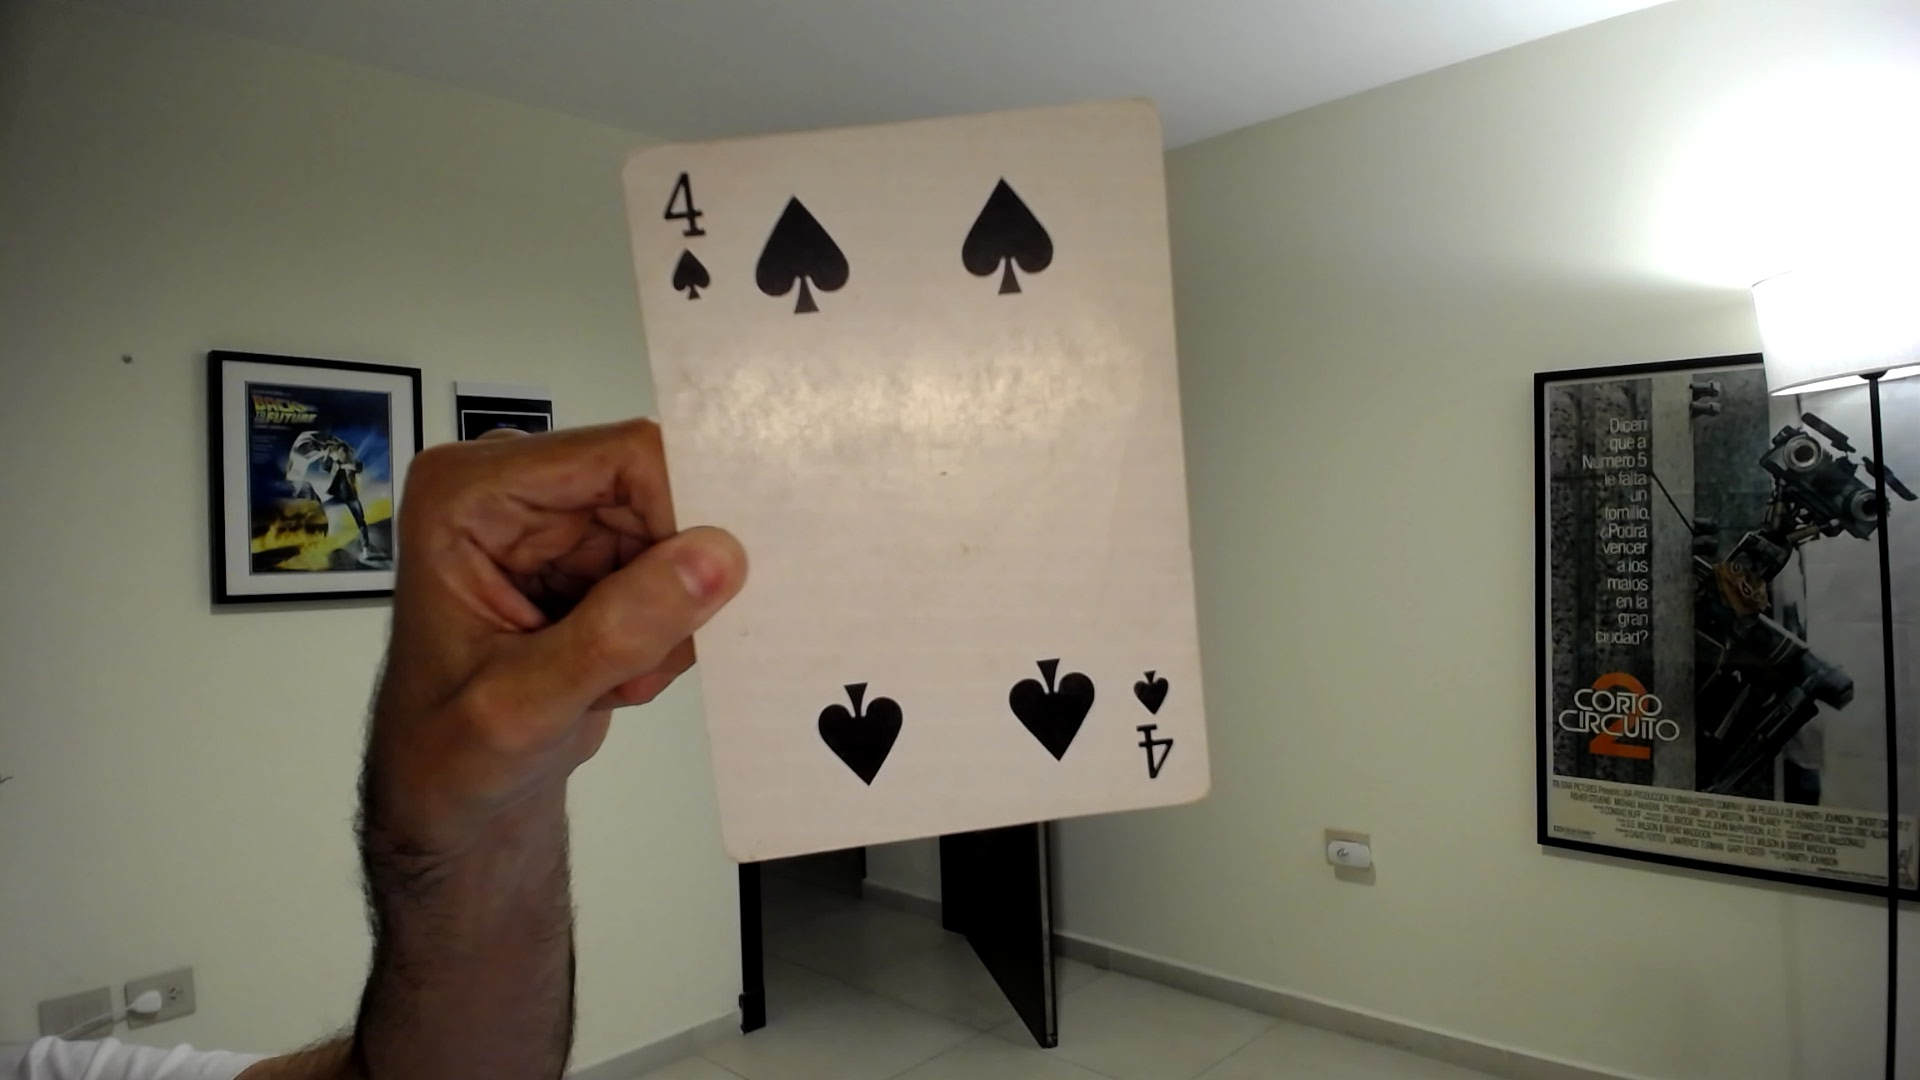

In [29]:
from IPython.display import Image
import cv2
from matplotlib import pyplot as plt

try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

frame = cv2.imread(filename)

## Run the object detection model on LandingLens cloud

In [30]:
from landingai.predict import Predictor
from landingai.visualize import overlay_predictions
        
predictor = Predictor(model_endpoint, api_key, api_secret)

# Run prediction and show raw results
results = predictor.predict(frame)
display(results)

[ObjectDetectionPrediction(score=0.9588286280632019, label_name='Spade', label_index=4, id='04d9878e-aee0-4990-a023-dc7a8dd7f19a', bboxes=(954, 171, 1060, 304)),
 ObjectDetectionPrediction(score=0.9402409791946411, label_name='Spade', label_index=4, id='50b7b023-8ce5-4fba-9d5c-0ab5ca4ac0fd', bboxes=(750, 189, 859, 324)),
 ObjectDetectionPrediction(score=0.79444819688797, label_name='Spade', label_index=4, id='a65a2275-8f82-4571-b1ab-896191899c69', bboxes=(1002, 653, 1105, 765)),
 ObjectDetectionPrediction(score=0.7681528925895691, label_name='Spade', label_index=4, id='1f03e0e0-cef5-4da3-bc39-f5273920f5d0', bboxes=(811, 679, 914, 793))]

## Visualize results

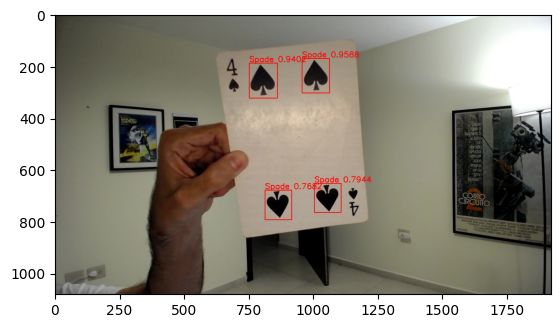

In [31]:
# Convert color space to RGB
frame2 = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
# Draw raw results on the original image
frame3 = overlay_predictions(results, image=frame2)

plt.imshow(frame3)
plt.show()


## Process results to count the number of suits

In [32]:
from IPython.display import display, Markdown
# Filter only high confidence detections and count them
filtered_results = [x for x in results if x.score  > 0.5] 
display(Markdown(f"# Found {len(filtered_results)} suits"))


# Found 4 suits